In [1]:
# common
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress INFO and WARNING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ML
from catboost import CatBoostClassifier, CatBoostRegressor

# DL
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# My
from backtest import Strategy, SignalStrategy
# from window_generator import WindowGenerator

# some definitions and settings
PRICE_DEC = 1
SIZE_DEC = 3
TEST_FRAC = 0.15
RANDOM_SEED = 73

PERIODS = {
    'long': 90,
    'short': 10
}

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def round_pred(y_pred, minstep = 0.5):
    return np.round(y_pred / minstep) * minstep

In [3]:
df = pd.read_csv('../../bars/bitmex-XBTUSD-1min.csv', parse_dates=['time'])
df.sort_values('time', ignore_index=True, inplace=True)
df.drop_duplicates(subset='time', ignore_index=True, inplace=True)
df.hbl = df.hbl.astype('int')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567865 entries, 0 to 567864
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        567865 non-null  datetime64[ns]
 1   open        567865 non-null  float64       
 2   high        567865 non-null  float64       
 3   low         567865 non-null  float64       
 4   close       567865 non-null  float64       
 5   avg         567865 non-null  float64       
 6   wavg        567865 non-null  float64       
 7   median      567865 non-null  float64       
 8   sum_vol     567865 non-null  int64         
 9   up_sum_vol  567865 non-null  int64         
 10  md_sum_vol  567865 non-null  int64         
 11  lo_sum_vol  567865 non-null  int64         
 12  net_vol     567865 non-null  int64         
 13  up_net_vol  567865 non-null  int64         
 14  md_net_vol  567865 non-null  int64         
 15  lo_net_vol  567865 non-null  int64         
 16  cn

Пропусков в самих данных также нет. 
Имеем дело со следующими столбцами:

| наименование | тип | описание |
|--------------|-------|--------|
|`time`        | datetime   | время начала периода (бара) |
|`open`        | float      | цена первой сделки периода   |    
|`high`        | float      | максимальная цена сделки периода |
|`low`         | float      | минимальная цена сделки периода   |    
|`close`       | float      | цена последней сделки периода |
|`avg`         | float      | средняя цена сделок периода |
|`wavg`        | float      | средневзвешенная по объему цена сделок периода |
|`median`      | float      | медиана цен сделок периода |
|`sum_vol`     | float      | сумма объемов сделок периода |
|`up_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `high` до `max(open, close)`      |
|`md_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `open` до `close`         |
|`lo_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `low` до `min(open, close)` |
|`net_vol`     | float      | нетто-объем сделок периода (сумма объемов покупок минус сумма объемов продаж) |
|`up_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `high` до `max(open, close)`        |
|`md_net_vol`  | float      | нетто-объем сделок в промежутке цен от `open` до `close`     |
|`lo_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `low` до `min(open, close)`   |      
|`cnt`         | int        | количество сделок за период|
|`hbl`         | int        | 1, если цена `high` была достигнута раньше, чем цена `low`, иначе 0

Важный нюанс - perpetual фьючерсы `XBTUSD` и `ETHUSD` на бирже `Bitmex` являются **инверсными**, т.е. единица лота в них не сама криптовалюта, а доллар, а PnL, наоборот, рассчитывается и начисляется в криптовалюте. Это стандартная практика для криптовалютных бирж, которые не могут рассчитывать и начислять PnL в фиате или аналогичных фиату стебл-коинах. В случае `ETHUSD` все еще сложнее, ведь его лот привязан к долларовому выражению `BTC`. Поэтому пока не будем трогать `ETHUSD`, но для `XBTUSD` лоты пересчитаем в единицы криптовалюты, чтобы было: 
* единообразно по всем биржам в данном проекте
* проще для рассчетов PnL в моделях
* проще для восприятия

In [5]:
for col in df.columns:
    if col[-4:] == '_vol':
        df[col] = np.round(df[col] / df.close, SIZE_DEC)

In [6]:
df.sample(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,md_sum_vol,lo_sum_vol,net_vol,up_net_vol,md_net_vol,lo_net_vol,cnt,hbl
245222,2021-06-20 08:35:00,35441.5,35441.5,35426.0,35426.0,35439.4,35439.7,35441.5,7.912,0.000,7.912,0.000,-7.912,0.000,-7.912,0.000,26,1
170715,2021-04-29 14:01:00,53699.5,53713.5,53653.0,53713.5,53676.8,53677.6,53663.0,50.186,0.000,6.909,43.277,-4.847,0.000,-0.148,-4.699,482,0
55370,2021-02-08 10:50:00,39429.0,39492.5,39429.0,39439.5,39459.3,39454.8,39458.5,159.233,142.089,17.144,0.000,36.390,48.688,-12.298,0.000,473,0
295103,2021-07-25 03:38:00,34251.0,34251.0,34250.5,34251.0,34250.8,34251.0,34251.0,0.893,0.000,0.820,0.073,0.747,0.000,0.820,-0.073,12,1
402194,2021-10-07 16:55:00,54285.5,54285.5,54162.5,54162.5,54209.9,54223.3,54205.0,25.001,0.000,25.001,0.000,-9.045,0.000,-9.045,0.000,204,1


In [7]:
cnt_up = 0
cnt_down = 0

def count_up_bars(x):
    global cnt_up
    cnt_up = (cnt_up + 1) if x > 0 else 0
    return cnt_up


def count_down_bars(x):
    global cnt_down
    cnt_down = (cnt_down + 1) if x < 0 else 0
    return cnt_down

In [8]:
prev_close = df.close.shift(1)
change_close = (df.close / prev_close) - 1
DEFAULT_EPS = 0.002 # 0.2%

df['up'] = (change_close > DEFAULT_EPS).astype('int')
df['down'] = (change_close < -DEFAULT_EPS).astype('int')
df['move'] = df['up'] - df['down']
df['up_in_row'] = df['up'].apply(count_up_bars)
df['down_in_row'] = df['down'].apply(count_down_bars)
df['TR'] = np.maximum(df.high, prev_close) - np.minimum(df.low, prev_close)
df.dropna(inplace=True)

Добавим еще столбцов:

| наименование | тип | описание |
|--------------|-------|--------|
|`up`          | int      | 1, если цена выросла больше шума, иначе 0 |
|`down`        | int      | 1, если цена упала больше шума, иначе 0   |    
|`move`        | int      | выросла или упала (`up-down`) |
|`up_in_row`   | int      | сколько периодов подряд цена росла   |    
|`down_in_row` | int      | сколько периодов подряд цена падала |
|`TR`          | int      | _True range_ |

In [9]:
def add_moving(data, period, key):
    roll = data.rolling(period, min_periods=1)
    std = roll.close.std().fillna(0)
    min_std = std.quantile(0.25)
    data[f'ma_{key}'] = roll.close.mean()
    data[f'std_{key}'] = np.maximum(std, min_std)
    data[f'ATR_{key}'] = roll.TR.mean()
    data[f'high_{key}'] = roll.high.max()
    data[f'low_{key}'] = roll.low.min()
    data[f'sum_vol_{key}'] = roll.sum_vol.mean()
    data[f'net_vol_{key}'] = roll.net_vol.mean()

При необходимости можно будет накидывать дополнительные признаки, вычисленные по скользящему окну:

| наименование | тип | описание |
|--------------|-------|--------|
|`ma_***`         | float      | _SMA(close)_, скользящая средняя цен закрытия  |
|`std_***`        | float      | стандартное отклоение цен закрытия  |    
|`ATR_***`        | float      | _Average True Range_ |
|`high_***`       | float      | максимальная цена внутри окна   |    
|`low_***`        | float      | минимальная цена внутри окна  |
|`sum_vol_***`    | float      | средний объем сделок внутри окна |
|`net_vol_***`    | float      | средний нетто-объем сделок внутри окна |

In [10]:
df.move.value_counts()

 0    525809
 1     21477
-1     20578
Name: move, dtype: int64

In [11]:
df.tail(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,...,md_net_vol,lo_net_vol,cnt,hbl,up,down,move,up_in_row,down_in_row,TR
567860,2022-01-30 23:55:00,37930.5,37930.5,37918.5,37919.0,37927.2,37927.0,37930.0,5.746,0.000,...,3.916,-0.19,34,1,0,0,0,0,0,12.0
567861,2022-01-30 23:56:00,37918.5,37918.5,37898.0,37898.0,37906.4,37909.3,37903.5,0.617,0.000,...,-0.480,0.00,10,1,0,0,0,0,0,21.0
567862,2022-01-30 23:57:00,37897.5,37897.5,37893.0,37893.0,37895.1,37894.9,37893.5,0.699,0.000,...,-0.161,0.00,17,1,0,0,0,0,0,5.0
567863,2022-01-30 23:58:00,37893.5,37893.5,37893.0,37893.0,37893.3,37893.3,37893.5,1.093,0.000,...,0.380,0.00,7,1,0,0,0,0,0,0.5
567864,2022-01-30 23:59:00,37893.5,37932.0,37893.5,37893.5,37904.5,37902.1,37893.5,7.455,3.296,...,4.154,0.00,73,0,0,0,0,0,0,39.0


## ML models

In [12]:
TRAIN_SIZE = int(len(df) * (1.0 - TEST_FRAC))

In [13]:
class MACrossStrategy(Strategy):
    def __init__(self, cross_type=1):
        if cross_type != 1 and cross_type != -1:
            raise Exception('`cross_type` should be either `1`(up) or `-1`(down)')
        
        self.cross_type = cross_type
        self.op = self.buy if cross_type == 1 else self.sell
        
        
    def prepare(self, data):
        cols = data.columns
        if not ('ma_long' in cols):
            raise Exception('missing `ma_long` column')
            
        if not ('ma_short' in cols):
            raise Exception('missing `ma_short` column')
            
        self.cross = (self.cross_type * (data.ma_short - data.ma_long)).shift(1)
        # shift is necessary because we can only use it on the next bar

        
    def next(self, row):
        # if prev's bar cross value satisfies out cross_type - make trade at current bar open
        if (self.cross[row.name] > 0):
            self.op(row, row.open)
        else:
            # otherwise - close position if present
            self.close(row, row.open)

In [14]:
MA_PERIOD_LONG = 13
MA_PERIOD_SHORT = 5

df_mac = df.copy(deep=False)
add_moving(df_mac, MA_PERIOD_LONG, 'long')
add_moving(df_mac, MA_PERIOD_SHORT, 'short')

for col1 in ['open', 'high', 'low', 'close']:
    for per in ['long', 'short']:
        for col2 in ['ma', 'high', 'low']:
            df_mac[f'{col1}_by_{col2}_{per}'] = (df_mac[col1] - df_mac[f'{col2}_{per}']) / df_mac[f'std_{per}']
            
df_mac['macd'] = (df_mac['ma_short'] - df_mac['ma_long']) / df_mac['std_long']
df_mac['macd_bin'] = (df_mac['macd'] > 0).astype('int')
df_mac['macd_bin_1'] = df_mac['macd_bin'].shift(1).fillna(0)
df_mac['tod'] = (df_mac.time.dt.hour * 60) + df_mac.time.dt.minute
data_train = df_mac.iloc[:TRAIN_SIZE]

In [15]:
ma_cross_res = MACrossStrategy().run(data_train)
ma_cross_res.summary()

Net profit:         -13627.50     Gross profit:      1166661.00
Raw profit:         -13627.50     Gross loss:       -1180288.50
Fee paid:                0.00     Max drawdown:        57012.50
Trades count:           21450     Profit factor:           0.99
Profitable:            36.20%     Recovery factor:        -0.24
Losing:                63.80%     Sharpe ratio:          -73.73


<AxesSubplot:xlabel='time', ylabel='pnl'>

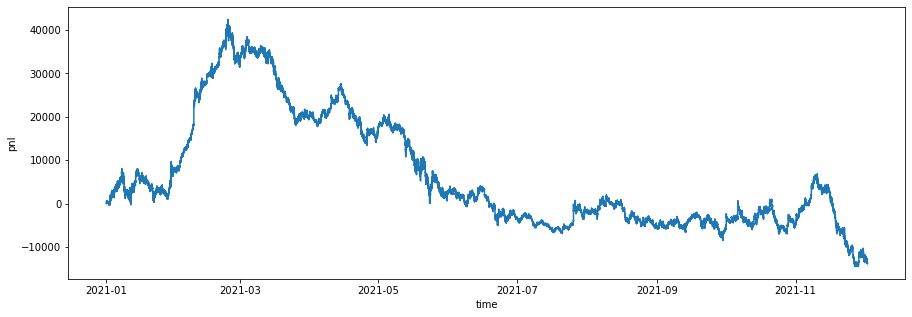

In [16]:
sns.lineplot(y=ma_cross_res.equity.pnl, x=data_train.time)

<AxesSubplot:xlabel='time', ylabel='pnl_open'>

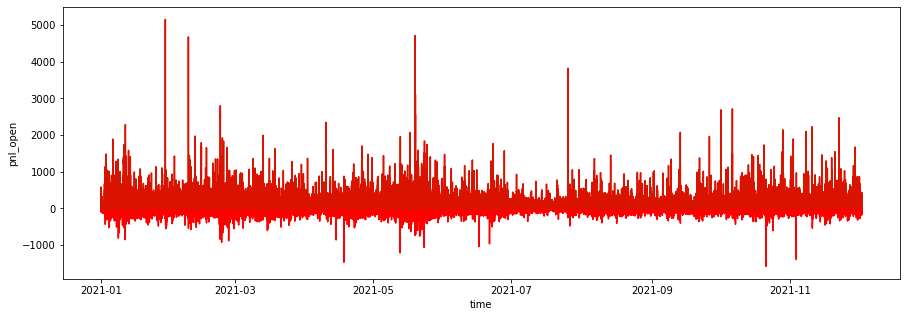

In [17]:
sns.lineplot(y=ma_cross_res.equity.pnl_open, x=data_train.time, color='r')
sns.lineplot(y=ma_cross_res.equity.pnl_open_max, x=data_train.time, color='g', alpha=0.15)

In [18]:
trades = ma_cross_res.trades
equity = ma_cross_res.equity
fix_pos = ma_cross_res.best_pos(min_bars_held=2)

In [19]:
trades

,pos,price_enter,price_exit,index_enter,index_exit,index_max,index_min,fee,pnl,pnl_max,pnl_min,result
0,1,28870.0,29359.0,24,84,74,29,0.0,489.0,585.0,-3.0,489.0
1,1,29425.0,29439.5,89,104,98,93,0.0,14.5,115.0,-25.0,14.5
2,1,29420.0,29420.0,114,115,114,114,0.0,0.0,0.0,0.0,0.0
3,1,29450.0,29421.5,118,127,120,126,0.0,-28.5,60.0,-28.0,-28.5
4,1,29390.0,29284.5,143,151,144,150,0.0,-105.5,26.5,-105.5,-105.5
...,...,...,...,...,...,...,...,...,...,...,...,...
21445,1,57230.0,57056.0,482557,482566,482558,482565,0.0,-174.0,117.0,-174.5,-174.0
21446,1,56644.0,56477.0,482585,482589,482585,482588,0.0,-167.0,58.5,-174.5,-167.0
21447,1,56389.5,56346.0,482604,482629,482623,482608,0.0,-43.5,356.5,-79.0,-43.5
21448,1,56245.0,56152.5,482657,482661,482657,482659,0.0,-92.5,45.5,-93.0,-92.5


In [20]:
mac_fix_res = SignalStrategy(fix_pos).run(data_train)
mac_fix_res.summary()

Net profit:        2272721.00     Gross profit:      2272854.50
Raw profit:        2272721.00     Gross loss:           -133.50
Fee paid:                0.00     Max drawdown:         1044.00
Trades count:           11365     Profit factor:       17025.13
Profitable:            99.67%     Recovery factor:      2176.94
Losing:                 0.33%     Sharpe ratio:         9403.11


In [21]:
mac_fix_res.trades

,pos,price_enter,price_exit,index_enter,index_exit,index_max,index_min,fee,pnl,pnl_max,pnl_min,result
0,1,28870.0,29454.5,24,75,74,29,0.0,584.5,585.0,-3.0,584.5
1,1,29425.0,29540.0,89,99,98,93,0.0,115.0,115.0,-25.0,115.0
2,1,29450.0,29511.0,118,121,120,118,0.0,61.0,60.0,0.0,61.0
3,1,29336.5,29400.0,165,170,169,165,0.0,63.5,63.0,0.0,63.5
4,1,29318.0,29359.5,185,196,195,188,0.0,41.5,41.5,-28.0,41.5
...,...,...,...,...,...,...,...,...,...,...,...,...
11360,1,56447.5,56513.5,482492,482496,482495,482492,0.0,66.0,63.5,0.0,66.0
11361,1,56631.5,56745.0,482507,482510,482509,482507,0.0,113.5,113.0,0.0,113.5
11362,1,56755.0,57181.5,482532,482548,482547,482532,0.0,426.5,439.5,-0.5,426.5
11363,1,56389.5,56746.5,482604,482624,482623,482608,0.0,357.0,356.5,-79.0,357.0


### Подход №1
пробуем обучить модель покупать-продавать в идеальных точках

`MACrossStrategy` входит в позицию на баре, следующем после пересечения средних - это непременное условие отсутствия "подглядывания в будущее". Кроме того, метод `best_pos` делает выход из позиции на баре, следующим за баром с максимальным доходом по текущей позиции - по той же причине. Поэтому для обучения модели целесобразно сдвинуть ряд `fix_pos` на 1 в прошлое

In [22]:
fix_pos = fix_pos.shift(-1).fillna(0).astype('int')

In [23]:
X_train, X_val, y_train, y_val = train_test_split(data_train.drop(columns='time'), fix_pos, 
                                                  test_size=TEST_FRAC, 
                                                  shuffle=False, 
                                                  random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((410281, 65), (410281,), (72403, 65), (72403,))

In [24]:
mac_catboost = CatBoostClassifier(iterations = 10000,
                                #depth=10,
                                #learning_rate = 0.5,
                                random_seed = RANDOM_SEED,
                                # eval_metric='Accuracy',
                                # custom_metric=['F1'],
                                eval_metric='Precision',
                                custom_metric=['F1'],
                                # od_wait=3000,
                                task_type='GPU')

mac_catboost.fit(X_train, y_train,
                eval_set=(X_val, y_val),
                verbose_eval=1000,
                use_best_model=True)

Learning rate set to 0.016459
0:	learn: 0.6567071	test: 0.6668896	best: 0.6668896 (0)	total: 21.4ms	remaining: 3m 34s
1000:	learn: 0.6785243	test: 0.6911859	best: 0.6913725 (952)	total: 16.8s	remaining: 2m 30s
2000:	learn: 0.6847414	test: 0.6908831	best: 0.6919474 (1292)	total: 33.2s	remaining: 2m 12s
3000:	learn: 0.6904813	test: 0.6909244	best: 0.6919474 (1292)	total: 49.6s	remaining: 1m 55s
4000:	learn: 0.6955591	test: 0.6909504	best: 0.6919474 (1292)	total: 1m 6s	remaining: 1m 38s
5000:	learn: 0.7008198	test: 0.6904407	best: 0.6919474 (1292)	total: 1m 22s	remaining: 1m 22s
6000:	learn: 0.7056506	test: 0.6902136	best: 0.6919474 (1292)	total: 1m 38s	remaining: 1m 5s
7000:	learn: 0.7105057	test: 0.6896350	best: 0.6919474 (1292)	total: 1m 55s	remaining: 49.4s
8000:	learn: 0.7151439	test: 0.6900657	best: 0.6919474 (1292)	total: 2m 11s	remaining: 32.9s
9000:	learn: 0.7196226	test: 0.6901957	best: 0.6919474 (1292)	total: 2m 28s	remaining: 16.4s
9999:	learn: 0.7232769	test: 0.6901446	best: 

In [25]:
y_pred_raw = mac_catboost.predict(X_val)
y_pred_raw.shape

(72403,)

In [37]:
accuracy_score(y_pred_raw, y_val), f1_score(y_pred_raw, y_val)

(0.8558070798171347, 0.7135173700675046)

In [27]:
feat_imp = pd.Series(data=mac_catboost.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False).head(10)

macd_bin               55.698314
macd                   25.874159
close_by_low_short      2.023840
close_by_ma_long        1.697187
macd_bin_1              1.453856
close_by_ma_short       1.145384
net_vol_long            1.142999
close_by_high_short     1.120792
std_short               1.033168
ATR_long                0.762883
dtype: float64

In [28]:
def validate_strategy(strategy, X_val, y_val, model, shift=1):
    print('Original strategy on validation data:')
    res_orig = strategy.run(X_val)
    res_orig.summary()
    print()
    print('Ideal footprint (y_val):')
    res_val = SignalStrategy(y_val, shift=shift).run(X_val)
    res_val.summary()
    print()
    print('Prediction footprint:')
    res_pred = SignalStrategy(model, shift=shift).run(X_val)
    res_pred.summary()
    
    return (res_orig, res_val, res_pred)

In [29]:
mac_orig_res, mac_val_res, mac_pred_res = validate_strategy(MACrossStrategy(), X_val, y_val, mac_catboost)

Original strategy on validation data:
Net profit:          -8404.50     Gross profit:       168330.00
Raw profit:          -8404.50     Gross loss:        -176734.50
Fee paid:                0.00     Max drawdown:        21386.50
Trades count:            3253     Profit factor:           0.95
Profitable:            33.14%     Recovery factor:        -0.39
Losing:                66.86%     Sharpe ratio:          -45.88

Ideal footprint (y_val):
Net profit:         334462.00     Gross profit:       334505.50
Raw profit:         334462.00     Gross loss:            -43.50
Fee paid:                0.00     Max drawdown:          523.00
Trades count:            1715     Profit factor:        7689.78
Profitable:            99.42%     Recovery factor:       639.51
Losing:                 0.58%     Sharpe ratio:         1404.53

Prediction footprint:
Net profit:          20391.00     Gross profit:       174542.50
Raw profit:          20391.00     Gross loss:        -154151.50
Fee paid:        

Сделок больше, поисследуем 

In [30]:
p0 = mac_pred_res.equity.pos
p1 = p0.shift(1)
p_1 = p0.shift(-1)
p_val = mac_val_res.equity.pos
onebar_deal = p0[(p0 != p1) & (p1 == p_1)]

In [31]:
len(onebar_deal), onebar_deal.value_counts()

(2920,
 1    1611
 0    1309
 Name: pos, dtype: int64)

In [32]:
one_bar_miss = p0[(p0 != p1) & (p1 == p_1) & (p0 != p_val)]
len(one_bar_miss), one_bar_miss.value_counts()

(2050,
 1    1044
 0    1006
 Name: pos, dtype: int64)

In [33]:
val_trades = mac_val_res.trades
bars_held_val = val_trades.index_exit - val_trades.index_enter

pred_trades = mac_pred_res.trades = mac_pred_res.trades
bars_held_pred = pred_trades.index_exit - pred_trades.index_enter

In [34]:
pred_trades[bars_held_pred == 1].result.sum(), val_trades[bars_held_val == 1].result.sum()

(-73525.0, 0.0)

<AxesSubplot:ylabel='Count'>

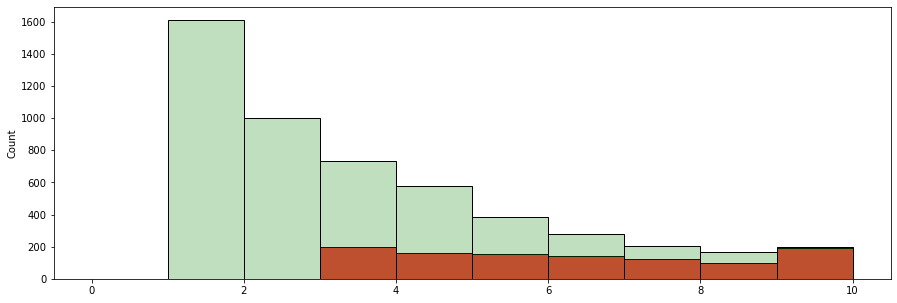

In [35]:
bins = [x for x in range(11)]
sns.histplot(data=bars_held_val, bins=bins, color='r')
sns.histplot(data=bars_held_pred, bins=bins, color='g', alpha=0.25)

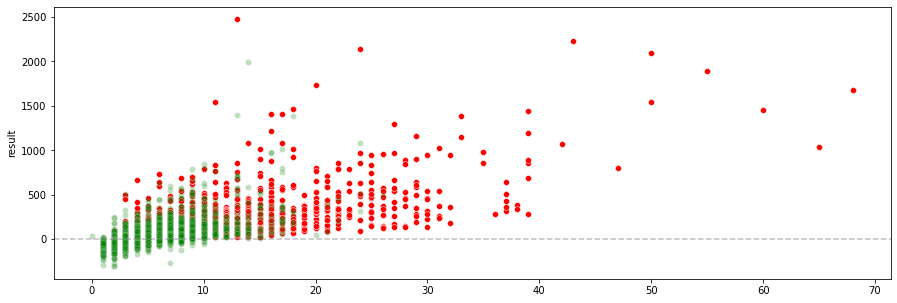

In [38]:
sns.scatterplot(y=val_trades.result, x=bars_held_val, color='r')
sns.scatterplot(y=pred_trades.result, x=bars_held_pred, color='g', alpha=0.25) \
    .axhline(0, color='gray', linestyle='--', alpha=0.5)

На графиках видно, что обученная модель хоть и показывает технически лучший результат в плане статистических метрик, но у нее существенный недостаток - большое количество трейдов протяженностью в 1 бар (вход и тут же выход), которые сильно ухудшают футпринт такой стратегии даже без учета проскальзываний и комиссий. В продакшне с этим невозможно бороться, поэтому такой подход нельзя назвать эффективным. Тем не менее, необходимо проверить подход на тестовой выборке

In [39]:
data_test = df_mac.iloc[TRAIN_SIZE:]

In [40]:
mac_test_res = MACrossStrategy().run(data_test)
mac_test_res.summary()

Net profit:           2371.50     Gross profit:       150447.50
Raw profit:           2371.50     Gross loss:        -148076.00
Fee paid:                0.00     Max drawdown:        11516.50
Trades count:            3649     Profit factor:           1.02
Profitable:            37.35%     Recovery factor:         0.21
Losing:                62.65%     Sharpe ratio:           18.15


In [41]:
MACrossStrategy().run(data_test, fee_pct=0.05).summary()

Net profit:        -161957.79     Gross profit:       102394.35
Raw profit:           2371.50     Gross loss:        -264352.14
Fee paid:           164329.29     Max drawdown:        11516.50
Trades count:            3649     Profit factor:           0.39
Profitable:            22.61%     Recovery factor:       -14.06
Losing:                77.39%     Sharpe ratio:        -1238.97


In [42]:
mac_test_sig_res2 = SignalStrategy(mac_catboost, shift=1).run(data_test)
mac_test_sig_res2.summary()

Net profit:          16120.00     Gross profit:       157020.00
Raw profit:          16120.00     Gross loss:        -140900.00
Fee paid:                0.00     Max drawdown:         3341.00
Trades count:            6207     Profit factor:           1.11
Profitable:            34.70%     Recovery factor:         4.82
Losing:                65.30%     Sharpe ratio:          198.07


In [43]:
SignalStrategy(mac_catboost, shift=1).run(data_test, fee_pct=0.05).summary()

Net profit:        -264666.90     Gross profit:        89957.45
Raw profit:          16120.00     Gross loss:        -354624.35
Fee paid:           280786.90     Max drawdown:         3341.00
Trades count:            6207     Profit factor:           0.25
Profitable:            16.53%     Recovery factor:       -79.22
Losing:                83.47%     Sharpe ratio:        -3244.85


## DL

In [90]:
from tensorflow.keras.utils import Sequence

class WindowGenerator(Sequence):
    def __init__(self, X, y, window_size, batch_size, start=None, end=None):
        # get shapes and ranges
        self.n_samples, self.n_features = X.shape        
        self.window_size = window_size
        self.batch_size = batch_size if batch_size > 0 else self.n_samples
        self.start_idx = max(window_size, (start if start != None else 0))
        self.end_idx = min(self.n_samples, (end if end != None else self.n_samples))
        # get datasets
        self.X = X
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            self.get_x = self.__get_x_pandas
            self.index_x = X.index[self.start_idx:self.end_idx]
        elif isinstance(X, np.ndarray):
            self.get_x = self.__get_x_numpy
            self.index_x = None
        else:
            raise Exception('Not supported X type')
            
        self.y = y
        if isinstance(y, pd.Series):
            self.get_y = self.__get_y_pandas
            self.index_y = y.index[self.start_idx:self.end_idx]
        elif isinstance(y, np.ndarray):
            self.get_y = self.__get_y_numpy
            self.index_y = None
        else:
            raise Exception('Not supported y type')
            
    
    def get_index(self):
        return self.index_y if self.index_x is None else self.index_x
    
    
    def __len__(self):
        return int(np.ceil((self.end_idx - self.start_idx) / self.batch_size))
    
    
    
    def __getitem__(self, idx):
        start = (idx * self.batch_size) + self.start_idx
        end = min(start + self.batch_size, self.end_idx) 
        batch_size = end - start
        X_batch = np.reshape(self.get_x(start, end), (batch_size, self.window_size, self.n_features))
        y_batch = self.get_y(start, end)
        return X_batch, y_batch
    
    
    def __get_x_pandas(self, start, end):
        return [self.X.iloc[i - self.window_size:i].to_numpy('float32') for i in range(start, end)]
    
    
    def __get_x_numpy(self, start, end):
        return [self.X[i - self.window_size:i,:] for i in range(start, end)]
    
    
    def __get_y_pandas(self, start, end):
        return self.y.iloc[start:end].to_numpy('float32')
    
    
    def __get_y_numpy(self, start, end):
        return self.y[start:end]
    
    

In [91]:
WINDOW_SIZE = MA_PERIOD_LONG + MA_PERIOD_SHORT
BATCH_SIZE = 1024

In [92]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [93]:
train_end = int(TRAIN_SIZE * (1.0 - TEST_FRAC))
val_end = TRAIN_SIZE

scaler = MinMaxScaler()

X = scaler.fit_transform(df_mac.drop(columns='time'))
y = fix_pos

input_shape = (WINDOW_SIZE, X.shape[1])

train_gen = WindowGenerator(X, y, WINDOW_SIZE, BATCH_SIZE, end=train_end)
val_gen = WindowGenerator(X, y, WINDOW_SIZE, BATCH_SIZE, start=train_end, end=TRAIN_SIZE)
test_gen = WindowGenerator(X, y, WINDOW_SIZE, BATCH_SIZE, start=TRAIN_SIZE)

In [124]:
mac_lstm1 = Sequential()
mac_lstm1.add(LSTM(256, input_shape=input_shape, activation="relu"))
mac_lstm1.add(Dropout(0.5))
mac_lstm1.add(Dense(32, activation="relu"))
mac_lstm1.add(Dropout(0.25))
mac_lstm1.add(Dense(1, activation="sigmoid"))
mac_lstm1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 256)               329728    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 337,985
Trainable params: 337,985
Non-trainable params: 0
_________________________________________________________________


In [125]:
metrics = [
    'binary_accuracy',
    Precision(name='precision'), 
    Recall(name='recall'), 
    Accuracy(name='accuracy')
]
mac_lstm1.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(learning_rate=1e-2),
                  metrics=metrics)
                  # metrics='accuracy')

In [126]:
checkpoint = ModelCheckpoint('./save/mac_lstm1.hdf5', 
                             monitor='val_binary_accuracy', 
                             verbose=0,
                             mode='max', 
                             save_best_only=True)
earlystop = EarlyStopping(monitor='val_binary_accuracy', 
                          patience=10, 
                          mode='max',
                          restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', 
                              factor=0.1, 
                              mode='max',
                              patience=5, 
                              min_lr=0.0001)
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [127]:
%%time
history = mac_lstm1.fit(train_gen,
                        steps_per_epoch = len(train_gen),
                        validation_data = val_gen, 
                        validation_steps = len(val_gen),
                        epochs = 100,
                        callbacks = callbacks_list,
                        verbose=1
                        )

Epoch 1/100
401/401 [==============================] - 22s 52ms/step - loss: 4.1116 - binary_accuracy: 0.7733 - precision: 0.5656 - recall: 0.3738 - accuracy: 0.0019 - val_loss: 0.3499 - val_binary_accuracy: 0.8123 - val_precision: 0.6090 - val_recall: 0.6433 - val_accuracy: 0.0000e+00
Epoch 2/100
401/401 [==============================] - 21s 52ms/step - loss: 0.3644 - binary_accuracy: 0.8000 - precision: 0.5922 - recall: 0.6246 - accuracy: 2.4375e-06 - val_loss: 0.3507 - val_binary_accuracy: 0.8058 - val_precision: 0.6322 - val_recall: 0.4866 - val_accuracy: 0.0000e+00
Epoch 3/100
401/401 [==============================] - 21s 52ms/step - loss: 0.3601 - binary_accuracy: 0.8033 - precision: 0.5956 - recall: 0.6463 - accuracy: 3.8999e-05 - val_loss: 0.3442 - val_binary_accuracy: 0.8136 - val_precision: 0.6085 - val_recall: 0.6604 - val_accuracy: 0.0000e+00
Epoch 4/100
401/401 [==============================] - 21s 52ms/step - loss: 0.3674 - binary_accuracy: 0.7986 - precision: 0.5898 -

KeyboardInterrupt: 

In [131]:
test = (pd.Series(mac_lstm1.predict(val_gen)[:,0], val_gen.get_index()) > 0.5).astype('int')

In [132]:
test.value_counts()

0    52462
1    19941
dtype: int64

In [133]:
f1_score(test, fix_pos.loc[test.index]), precision_score(test, fix_pos.loc[test.index])

(0.649039740384104, 0.6911006627768651)